In [1]:
! pip install transformers newspaper3k

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# ! python -m spacy download en_core_web_sm

In [3]:
import os
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from transformers import pipeline
from newspaper import Article
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from collections import Counter
import spacy
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
MAIN_FOLDER = '/content/drive/MyDrive/url_classification/'
HTML_FOLDER = MAIN_FOLDER + 'html_files_Nov-24-2022/'
os.chdir(MAIN_FOLDER)

In [6]:
TARGET = 'label'
TEXT = 'text'

In [28]:
def get_html_files(html_folder=HTML_FOLDER):
  html_files = os.listdir(HTML_FOLDER)
  return html_files

html_files = get_html_files()

In [29]:
def create_df(csv_path='url_classification_temporary.csv', usecols=['File Name', 'Label']):
  df = pd.read_csv(csv_path, usecols = usecols)
  df.rename(columns={usecols[0]: 'filename', usecols[1]: 'label'}, inplace=True)
  df = df[~df['filename'].isna()]
  print(f'Original shape: {df.shape}')
  df = df[df['label'] != '-']
  df.reset_index(drop=True, inplace=True)
  print(f'Final shape: {df.shape}')
  return df

df = create_df('url_classification_temporary4.csv')

Original shape: (281, 2)
Final shape: (223, 2)


In [30]:
def get_target_distribution(df, normalize=False):
  return df[TARGET].value_counts(normalize=normalize)

get_target_distribution(df, normalize=True)

Home Page        0.336323
Blog             0.228700
Product Page     0.152466
MISC             0.147982
Article          0.040359
White Paper      0.035874
Event            0.022422
Education        0.017937
Video Content    0.004484
Online Course    0.004484
Q&A Page         0.004484
About Page       0.004484
Name: label, dtype: float64

In [31]:
def read_htmls(df):
  current_filenames = df['filename'].values
  htmls = list()

  for i, filename in enumerate(current_filenames):
    try:
      with open(f'{HTML_FOLDER}{filename}') as f:
        html = f.read()
        htmls.append(html)
    except FileNotFoundError:
      print(f'File {i} not found: "{filename}"')
  
  return htmls

htmls = read_htmls(df)

In [32]:
def read_articles(htmls):
  toi_articles = list()

  for html in htmls:
    toi_article = Article(url = ' ', language="en")
    toi_article.set_html(html)
    toi_article.parse()
    toi_article.nlp()
    toi_articles.append(toi_article)

  return toi_articles

toi_articles = read_articles(htmls)

In [33]:
def create_y(df):
  return df['label'].tolist()

y = create_y(df)

In [34]:
assert len(toi_articles) == len(y)

In [35]:
def create_summary(toi_articles):
  title_and_summary = [(toi_article.title + '. ' + toi_article.summary).replace('\n', ' ') for toi_article in toi_articles]
  return title_and_summary

title_and_summary = create_summary(toi_articles)

In [36]:
def create_df_text(text, y, minimum_words=None, maximum_classes=None):
  df_text = pd.DataFrame({TEXT: title_and_summary, TARGET: y})
  df_text[TEXT] = df_text.loc[:, TEXT].str.lower()
  if minimum_words:
    df_text = df_text[df_text[TEXT].str.split().str.len() > minimum_words]
  if maximum_classes:
    relevant_labels = df_text[TARGET].value_counts()[:maximum_classes].index
    df_text = df_text[df_text[TARGET].isin(relevant_labels)]
  return df_text

df_text = create_df_text(title_and_summary, y, minimum_words=30, maximum_classes=4)

In [37]:
def split_X_y(df, test_size=0.2):
  X = df.drop(TARGET, axis=1)
  y = df[TARGET]

  X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                      test_size=test_size,
                                                      stratify=y, 
                                                      random_state=0)
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_X_y(df_text, test_size=0.2)

In [38]:
def get_baseline_accuracy(y_train, y_test):
  majority_class = y_train.value_counts().index[0]
  accuracy = sum(y_test == majority_class) / len(y_test)
  return accuracy

get_baseline_accuracy(y_train, y_test)

0.34285714285714286

In [39]:
def get_most_common_tokens(amount=10):
  tokenized = [word_tokenize(string) for string in X_train[TEXT]]
  flat_list = [item for sublist in tokenized for item in sublist]
  return Counter(flat_list).most_common(amount)

get_most_common_tokens(amount=5)

[('.', 661), (',', 532), ('to', 457), ('the', 408), ('and', 351)]

In [40]:
def fit_transform_articles(X_train, vectorizer='count'): # I could add stop_words=False/True as a parameter if I see later that it could make a difference
  articles = X_train[TEXT]
  if vectorizer == 'count':
    vectorizer = CountVectorizer()
  elif vectorizer == 'tfidf':
    vectorizer = TfidfVectorizer()
  else:
    raise Exception("vectorizer should be either 'count' or 'tfidf'")
  X = vectorizer.fit_transform(articles)
  return X

X = fit_transform_articles(X_train, vectorizer='tfidf') # to see output: X.toarray()

In [41]:
def load_nlp():
  nlp = spacy.load('en_core_web_sm')
  return nlp

nlp = load_nlp()

In [42]:
def lemmatize_text(X_train, nlp):
  lemmatized_text = list()
  for text in X_train[TEXT]:
    lemmas = [token.lemma_.lower() for token in nlp(text)]
    lemmatized_text.append(lemmas)

  return lemmatized_text

lemmatized_text = lemmatize_text(X_train, nlp)

In [43]:
def fit_transform_articles(X_train, X_test, vectorizer='count'):
  if vectorizer == 'count':
    vectorizer = CountVectorizer(max_features=10000, ngram_range=(1, 3))
  elif vectorizer == 'tfidf':
    vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
  else:
    raise Exception("vectorizer should be either 'count' or 'tfidf'")
  X_train_transformed = vectorizer.fit_transform(X_train[TEXT])
  X_test_transformed = vectorizer.transform(X_test[TEXT])

  return X_train_transformed, X_test_transformed, vectorizer

X_train_transformed, X_test_transformed, vectorizer = fit_transform_articles(X_train, X_test, vectorizer='tfidf') # to see output: X_train.toarray() or X_test.toarray()

In [44]:
def fit_model(model=LogisticRegression(max_iter=3000), X_train=X_train_transformed, y_train=y_train):
  clf = model
  clf.fit(X_train, y_train)
  return clf

clf = fit_model(model=LogisticRegression(max_iter=3000), 
                X_train=X_train_transformed, 
                y_train=y_train)

In [45]:
def predict(clf, X_test=X_test_transformed):
  y_pred = clf.predict(X_test)
  return y_pred

y_pred = predict(clf, X_test=X_test_transformed)

In [46]:
def get_accuracy(y_train, y_test):
  accuracy = sum(y_pred == y_test) / len(y_test)
  return accuracy

get_accuracy(y_train, y_test)

0.5428571428571428

In [47]:
def print_important_features(clf, features=5):
  coef_importances = np.argsort(clf.coef_, axis=1)
  for i, class_ in enumerate(coef_importances[:, :features]):
      print(f'Class "{clf.classes_[i]}" - {features} most important features: '
            f'{vectorizer.get_feature_names_out()[class_]}')
      
print_important_features(clf, features=5)

Class "Blog" - 5 most important features: ['guest' 'our' 'and' 'seo' 'guest post']
Class "Home Page" - 5 most important features: ['keyword' 'guest' 'post' 'your' 'stock']
Class "MISC" - 5 most important features: ['search' 'the' 'of' 'how' 'what']
Class "Product Page" - 5 most important features: ['guest' 'marketing' 'keyword' 'has' 'post']


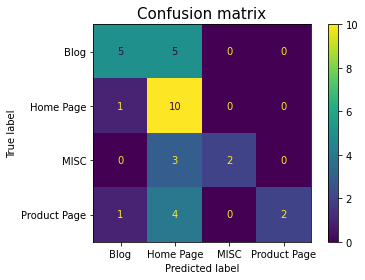

In [27]:
def print_confusion_matrix(y_test, y_pred):
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  plt.title('Confusion matrix', size=15)
  plt.show()

print_confusion_matrix(y_test, y_pred) # until row 262

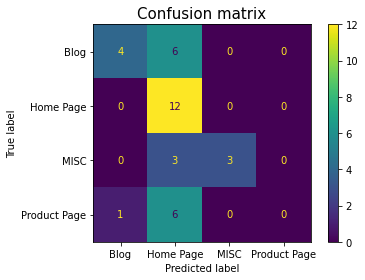

In [48]:
print_confusion_matrix(y_test, y_pred) # after (with more data) until row 281